In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import shutil
from google.colab import drive

Load CIFAR-10

In [3]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Filter images containing frogs (class 6 in CIFAR-10)
frog_indices_train = np.where(train_labels == 6)[0]
frog_indices_test = np.where(test_labels == 6)[0]

# Create new labels: 1 for frogs, 0 for everything else
train_labels_binary = np.zeros((len(train_labels), 1))
train_labels_binary[frog_indices_train] = 1
test_labels_binary = np.zeros((len(test_labels), 1))
test_labels_binary[frog_indices_test] = 1

# Filter images containing frogs and non-frog images
train_images_frog = train_images[frog_indices_train]
train_images_nonfrog = np.delete(train_images, frog_indices_train, axis=0)
test_images_frog = test_images[frog_indices_test]
test_images_nonfrog = np.delete(test_images, frog_indices_test, axis=0)

# Combine frog and non-frog images and labels
train_images_final = np.concatenate((train_images_frog, train_images_nonfrog))
test_images_final = np.concatenate((test_images_frog, test_images_nonfrog))
train_labels_final = np.concatenate((train_labels_binary[frog_indices_train], np.zeros((len(train_images_nonfrog), 1))))
test_labels_final = np.concatenate((test_labels_binary[frog_indices_test], np.zeros((len(test_images_nonfrog), 1))))

# Determine the number of non-frog images to delete
num_images_to_delete = 30000

# Delete the specified number of non-frog images
train_images_nonfrog_balanced = np.delete(train_images_nonfrog, range(num_images_to_delete), axis=0)

# Update the combined train images and labels
train_images_final = np.concatenate((train_images_frog, train_images_nonfrog_balanced))
train_labels_final = np.concatenate((train_labels_binary[frog_indices_train], np.zeros((len(train_images_nonfrog_balanced), 1))))

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Fit the ImageDataGenerator to your training data
datagen.fit(train_images_final)

170498071/170498071 [==============================] - 13s 0us/step


Declare Model

In [4]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.35),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.45),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                        

Training

Epoch 1/30
625/625 [==============================] - 30s 30ms/step - loss: 0.9090 - accuracy: 0.7678 - val_loss: 0.6166 - val_accuracy: 0.8320
Epoch 2/30
625/625 [==============================] - 19s 30ms/step - loss: 0.6089 - accuracy: 0.8275 - val_loss: 0.4510 - val_accuracy: 0.8957
Epoch 3/30
625/625 [==============================] - 18s 28ms/step - loss: 0.4691 - accuracy: 0.8399 - val_loss: 0.2997 - val_accuracy: 0.9000
Epoch 4/30
625/625 [==============================] - 18s 29ms/step - loss: 0.4010 - accuracy: 0.8505 - val_loss: 0.5065 - val_accuracy: 0.7951
Epoch 5/30
625/625 [==============================] - 18s 29ms/step - loss: 0.3714 - accuracy: 0.8594 - val_loss: 0.6570 - val_accuracy: 0.6983
Epoch 6/30
625/625 [==============================] - 17s 27ms/step - loss: 0.3626 - accuracy: 0.8648 - val_loss: 0.4853 - val_accuracy: 0.8178
Epoch 7/30
625/625 [==============================] - 23s 37ms/step - loss: 0.3495 - accuracy: 0.8688 - val_loss: 0.2576 - val_accuracy:

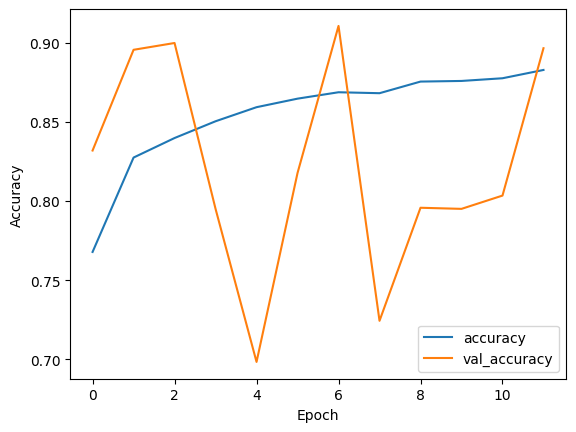

In [5]:
# Training

# Split dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images_final, train_labels_final, test_size=0.2, random_state=42)

# Compile model with binary cross-entropy loss and appropriate optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model on training set, validating on validation set
# history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
# Train your model with augmented data
history = model.fit(datagen.flow(train_images_final, train_labels_final, batch_size=32), epochs=30, validation_data=(test_images_final, test_labels_final),callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


Evaluation

In [6]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_images_final, test_labels_final)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Optionally, you can calculate additional evaluation metrics using scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions on test set
y_pred = model.predict(test_images_final)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels_final, y_pred_binary)
precision = precision_score(test_labels_final, y_pred_binary)
recall = recall_score(test_labels_final, y_pred_binary)
f1 = f1_score(test_labels_final, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

313/313 [==============================] - 1s 4ms/step - loss: 0.2576 - accuracy: 0.9108
Test Loss: 0.25762999057769775
Test Accuracy: 0.9107999801635742
313/313 [==============================] - 2s 5ms/step
Accuracy: 0.9108
Precision: 0.5338345864661654
Recall: 0.852
F1-score: 0.6563944530046225


Confusion Matrix

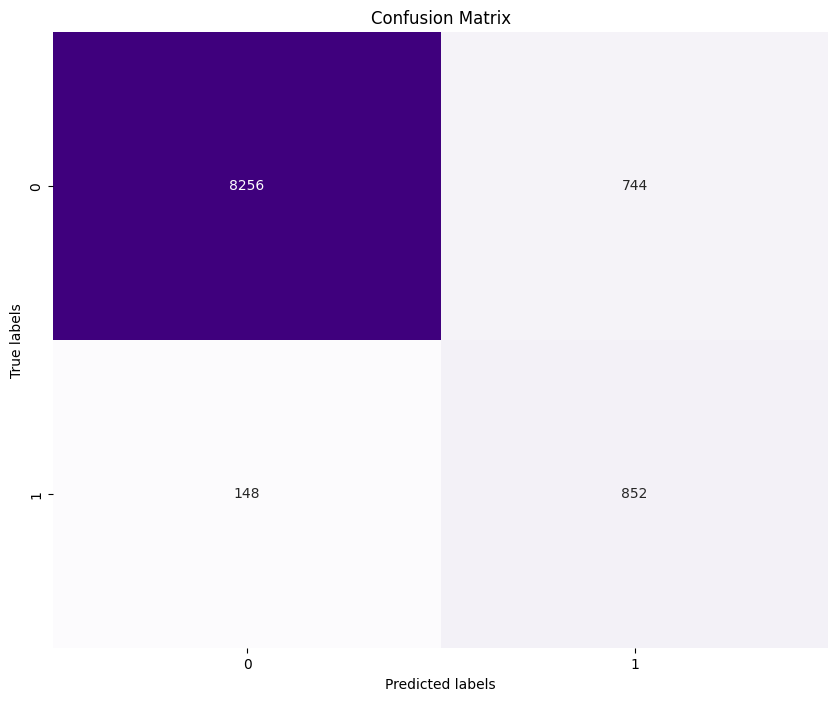

In [7]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels_final, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Mount Google Drive
drive.mount('/content/drive')

# Save the model to Google Drive
model.save('/content/drive/My Drive/ML/frog_detect_model.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/My Drive/ML/frog_detect_model.tflite', 'wb') as f:
    f.write(tflite_model)

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
